# Predicting Medical Insurance Costs
The goal of this project is to build a predictive model for individual medical bills based on demographic and personal data. Using [Kaggle's Medical Cost Data Set](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download), which includes patient variables such as age, gender, bmi, children, smoker status, and geography, we want to identify how these factors influence overall medical expenses acquired. By creating an accurate predictive model, we can assist hospitals in better forecasting income and planning for the medical operations that their patients require.

Linear regression was chosen for this regression problem because it is simple and good at predicting continuous, positive integers. We will investigate the correlations between patient characteristics and medical costs, eventually developing an effective model that can provide significant insights and aid in strategic decision-making in the healthcare industry.

## Data Exploration 
let's start by reading the data

In [1]:
import pandas as pd
import numpy as np

insurance = pd.read_csv("insurance.csv")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


The `charges` column is our outcome, while everything else are the potential predictors to use in the model.
let's see how the `charges` column looks like.

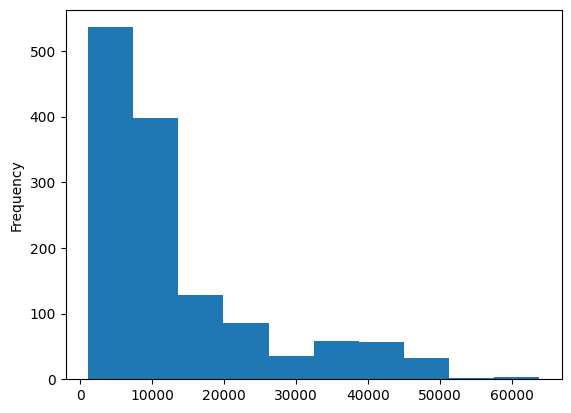

In [3]:
import matplotlib.pyplot as plt

insurance['charges'].plot.hist()
plt.show()

The `charges` column is highly skewed to the right. Extremely high insurance costs are more common than extremely low ones. As a result, the model's errors are unlikely to be centered at zero. It may be worthwhile to log-transform the outcome.

array([[<AxesSubplot:title={'center':'log_charges'}>]], dtype=object)

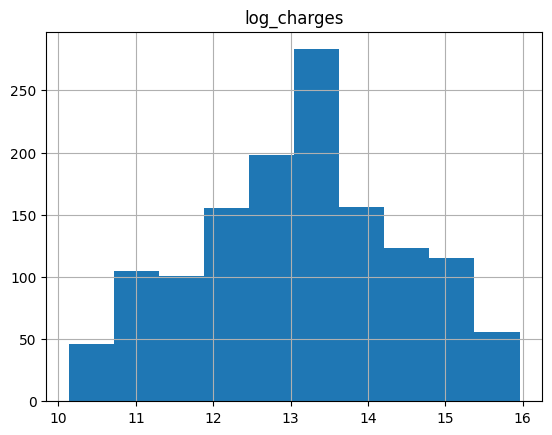

In [4]:
insurance["log_charges"] = np.log2(insurance["charges"])

insurance.hist("log_charges")

The log-transformed charge values are more central, which is what we wanted. This increases the likelihood that the errors will be unbiased.

### Relationship between the outcome column(`charges`) and Numerical columns
Checking the correlation between the continuous columns in the insurance data

In [5]:
insurance.corr()

,age,bmi,children,charges,log_charges
age,1.000000,0.109272,0.042469,0.299008,0.527834
bmi,0.109272,1.000000,0.012759,0.198341,0.132669
children,0.042469,0.012759,1.000000,0.067998,0.161336
charges,0.299008,0.198341,0.067998,1.000000,0.892964
log_charges,0.527834,0.132669,0.161336,0.892964,1.000000


age has `30%` correlation with charges, bmi has `19.8%` correlation, and number of children has `6.7%` correlation.

### Distribution between `log_charges` column and the categorical columns

<AxesSubplot:title={'center':'log_charges'}, xlabel='sex'>

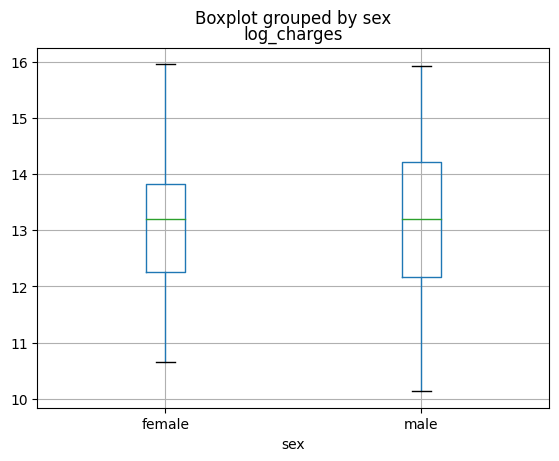

In [6]:
insurance.boxplot(column = ["log_charges"], by = "sex")

<AxesSubplot:title={'center':'log_charges'}, xlabel='smoker'>

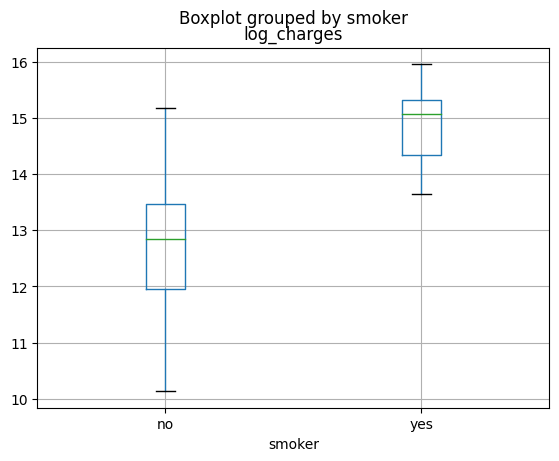

In [7]:
insurance.boxplot(column = ["log_charges"], by = "smoker")

<AxesSubplot:title={'center':'log_charges'}, xlabel='region'>

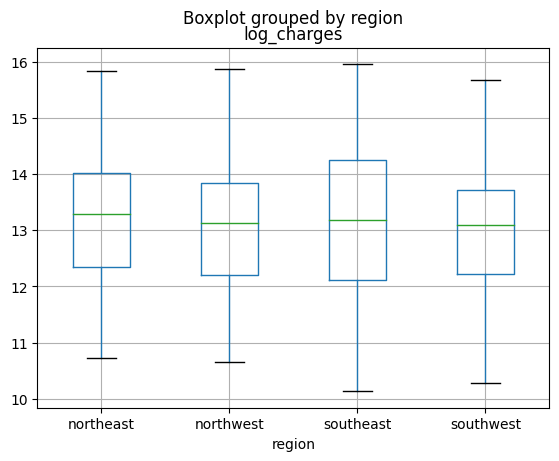

In [8]:
insurance.boxplot(column = ["log_charges"], by = "region")

Males appear to have a wider distribution of charges than females. Smokers face significantly higher costs than non-smokers. There seem to be few significant distinctions between regions.

## Dividing The Data
According to the univariate associations mentioned above, `age`, `bmi`, and `smoker` are all related with greater `charges`. We will include these predictors in our final model.

In [9]:
insurance["is_smoker"] = insurance["smoker"].apply( lambda x: 1 if x == "yes" else 0)
insurance.head()

,age,sex,bmi,children,smoker,region,charges,log_charges,is_smoker
0,19,female,27.900,0,yes,southwest,16884.92400,14.043448,1
1,18,male,33.770,1,no,southeast,1725.55230,10.752842,0
2,28,male,33.000,3,no,southeast,4449.46200,12.119415,0
3,33,male,22.705,0,no,northwest,21984.47061,14.424197,0
4,32,male,28.880,0,no,northwest,3866.85520,11.916945,0


In [10]:
from sklearn.model_selection import train_test_split

# Splitting the data up into a training and test set

X = insurance[["age", "bmi", "is_smoker"]]
y = insurance["log_charges"]

# 80% for training set, 20% for test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

## Build The Model
Now that we have divided the data into both a `training` and `test set`, we are ready to develop our predictive linear model.

In [11]:
from sklearn.linear_model import LinearRegression

# Training and checking model performance on training set
insurance_model = LinearRegression()
insurance_model.fit(X_train, y_train)

LinearRegression()

In [12]:
from sklearn.metrics import mean_squared_error,r2_score

# Get predicted values by model
y_pred = insurance_model.predict(X_train)

# MSE on the log scale for the insurance charges
mean_squared_error(y_train, y_pred)

0.45188410556701514

In [13]:
# MSE on the original scale for the insurance charges
np.exp(mean_squared_error(y_train, y_pred))

1.5712698365981919

In [14]:
# Coefficient of determination
r2_score(y_train, y_pred)

0.7401147505859649

The model's training MSE is `0.454`, compared to `1.57` on the original scale. The `coefficient of determination` means the model can explain for `74%` of the variation in log-insurance charges. These preliminary findings are encouraging, but remember that these are optimistic estimates.

## Residual Diagnostics
We now have a working predictive model for medical costs. Before we examine it more closely, we should make sure that the linear regression assumptions are met.

<AxesSubplot:xlabel='fitted', ylabel='residuals'>

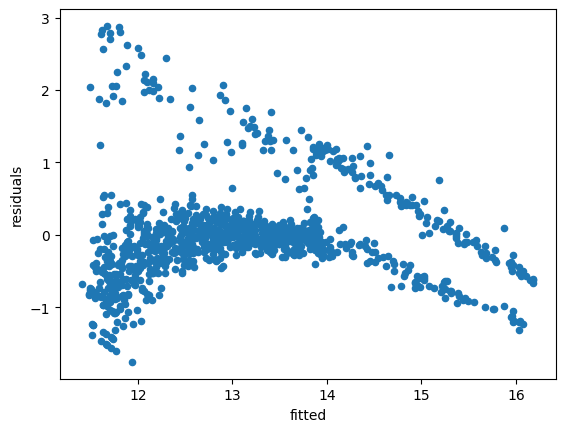

In [15]:
# Quick visual check of residuals
check = pd.DataFrame()
check["residuals"] = y_train - y_pred
check["fitted"] = y_pred

check.plot.scatter(x = "fitted", y = "residuals")

In [16]:
# Getting the non-intercept coefficients
insurance_model.coef_

array([0.04983948, 0.01422752, 2.21807367])

The residuals imply various violations of the linear regression assumptions. As the fitted values increase, the residuals decrease. We expect an even band centered around zero. This does not render the model predictions worthless, but it calls into question the linear regression assumptions.

## Interpreting The Model
Remember that one of the advantages of a linear model is that we can simply understand what the calculated coefficients mean. The model enables us to discuss how changes in the predictors relate to changes in the outcome (without causing them).

+ A year rise in the subject is associated with a `0.04` increase in `log charges`, assuming `smoking status` and `bmi` remain constant. Charges on the standard scale have increased by about `4%`.
+ A unit increase in the subject's `bmi` is connected with a `0.01` rise in `log charges`, while `smoking status` and `age` remain unchanged. The rates on the usual scale have increased by about `1.5%`.
+ A `Smoker` is associated with a `2.21` rise in `log charges`, while `age` and `bmi` remain unchanged. `Charges` on the usual scale have increased by around `221%`.

We aren't concerned with whether these changes are statistically significant, therefore we don't know if these connections are actually non-zero. Our major purpose is prediction.

## Final Model Evaluation
The training error is nearly always overly optimistic, therefore we shouldn't use it to determine the model's prediction capabilities. It's time to examine how the model performs on the test data, which consists of new observations that have not been trained on. If we are to utilize predictions in the new world, they must be correct for any new observations.

In [17]:
# Getting MSE on test model
test_pred = insurance_model.predict(X_test)
mean_squared_error(y_test, test_pred)

0.43968114625714

In [18]:
# Putting the outcome (in log-terms) back into the original scale
np.exp(mean_squared_error(y_test, test_pred))

1.5522122109248526

## Conclusion
The test MSE was roughly `0.435`, while the training MSE was approximately `0.454`. In this case, the two errors match up rather well, indicating that the model is not overfit. The residuals indicate that the model predicts far lower costs for participants who were actually paid much higher. As a result, the model struggles to account for the increasing expenses. Overall, the model's projections are too conservative.

We may improve the model by introducing more complex components into the regression, such as interactions or quadratic terms.